In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=100 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
cd_orig = target_df.iloc[:,3].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
cd = (cd_orig-np.min(cd_orig))/(np.max(cd_orig)-np.min(cd_orig))

In [27]:
y = cd.reshape((-1,1))

In [28]:
y.shape

(144, 1)

In [29]:
x_para_all, x_para_test, x_all, x_test, y_all, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [30]:
x_para_train, x_para_val, x_train, x_val, y_train, y_val = train_test_split(x_para_all, x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 100)   500         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 100)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2700)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [36]:
ckpt_name = model_directory + "20221130steadyValidation_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettings_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [37]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [38]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 10s - loss: 0.1161 - rmse: 0.3407
Epoch 1: val_loss improved from inf to 0.09201, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 3s 59ms/step - loss: 0.1336 - rmse: 0.3655 - val_loss: 0.0920 - val_rmse: 0.3033 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.1601 - rmse: 0.4001
Epoch 2: val_loss improved from 0.09201 to 0.08322, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 22ms/step - loss: 0.1240 - rmse: 0.3521 - val_loss: 0.0832 - val_rmse: 0.2885 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.1556 - rmse: 0.3945
Epoch 3: val_loss improved from 0.08322 to 0.07357, saving model to D:\TrainedModels\2022113020221130s

5/5 [==============================] - 0s 23ms/step - loss: 0.0388 - rmse: 0.1970 - val_loss: 0.0204 - val_rmse: 0.1429 - lr: 1.0000e-04
Epoch 22/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - rmse: 0.1538
Epoch 22: val_loss improved from 0.02043 to 0.01835, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 23ms/step - loss: 0.0360 - rmse: 0.1896 - val_loss: 0.0184 - val_rmse: 0.1355 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0312 - rmse: 0.1767
Epoch 23: val_loss improved from 0.01835 to 0.01805, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 23ms/step - loss: 0.0344 - rmse: 0.1856 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 24/10000
1/5 [=====>.......................

Epoch 44/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0040 - rmse: 0.0631
Epoch 44: val_loss did not improve from 0.00572
5/5 [==============================] - 0s 13ms/step - loss: 0.0071 - rmse: 0.0844 - val_loss: 0.0061 - val_rmse: 0.0783 - lr: 1.0000e-04
Epoch 45/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 45: val_loss improved from 0.00572 to 0.00566, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 0.0070 - rmse: 0.0839 - val_loss: 0.0057 - val_rmse: 0.0752 - lr: 1.0000e-04
Epoch 46/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0090 - rmse: 0.0951
Epoch 46: val_loss did not improve from 0.00566
5/5 [==============================] - 0s 13ms/step - loss: 0.0069 - rmse: 0.0833 - val_loss: 0.0069 - val_rmse: 0.0833 - lr: 1.0000e-04
Epoch 47/10000
1/5 [=====>.............

1/5 [=====>........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0886
Epoch 95: val_loss did not improve from 0.00343
5/5 [==============================] - 0s 13ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0036 - val_rmse: 0.0599 - lr: 1.0000e-04
Epoch 96/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0484
Epoch 96: val_loss improved from 0.00343 to 0.00337, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0033 - rmse: 0.0575 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 97/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0670
Epoch 97: val_loss did not improve from 0.00337
5/5 [==============================] - 0s 14ms/step - loss: 0.0038 - rmse: 0.0617 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 98/10000
1/5 [=====>........................] - 

Epoch 121/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 121: val_loss did not improve from 0.00307
5/5 [==============================] - 0s 14ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 122/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0056 - rmse: 0.0750
Epoch 122: val_loss improved from 0.00307 to 0.00304, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0033 - rmse: 0.0574 - val_loss: 0.0030 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 123/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0505
Epoch 123: val_loss did not improve from 0.00304
5/5 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0542 - val_loss: 0.0032 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 124/10000
1/5 [=====>......

5/5 [==============================] - 0s 28ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 149/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 149: val_loss did not improve from 0.00285
5/5 [==============================] - 0s 14ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 150/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 150: val_loss improved from 0.00285 to 0.00285, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 151/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 151: val_loss did not improve from 0.00285
5/5 [============================

5/5 [==============================] - 0s 14ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0027 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 204/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 204: val_loss did not improve from 0.00270
5/5 [==============================] - 0s 14ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 205/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0346
Epoch 205: val_loss did not improve from 0.00270
5/5 [==============================] - 0s 15ms/step - loss: 0.0024 - rmse: 0.0490 - val_loss: 0.0028 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 206/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4564e-04 - rmse: 0.0291
Epoch 206: val_loss did not improve from 0.00270
5/5 [==============================] - 0s 14ms/step - loss: 0.0023 - rmse: 0.0479 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 207/10000
1/5 [=

5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0460 - val_loss: 0.0031 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 232/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0480
Epoch 232: val_loss did not improve from 0.00262
5/5 [==============================] - 0s 15ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0026 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 233/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0389
Epoch 233: val_loss did not improve from 0.00262
5/5 [==============================] - 0s 15ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0030 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 234/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6867e-04 - rmse: 0.0277
Epoch 234: val_loss did not improve from 0.00262
5/5 [==============================] - 0s 14ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-04
Epoch 235/10000
1/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0028 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 260/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0583
Epoch 260: val_loss did not improve from 0.00255
5/5 [==============================] - 0s 15ms/step - loss: 0.0022 - rmse: 0.0471 - val_loss: 0.0026 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 261/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5253e-04 - rmse: 0.0255
Epoch 261: val_loss did not improve from 0.00255
5/5 [==============================] - 0s 15ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0026 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 262/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0500
Epoch 262: val_loss did not improve from 0.00255
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0462 - val_loss: 0.0026 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 263/10000
1/5 [=

Epoch 287/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 287: val_loss did not improve from 0.00244
5/5 [==============================] - 0s 14ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0025 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 288/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0386
Epoch 288: val_loss did not improve from 0.00244
5/5 [==============================] - 0s 14ms/step - loss: 0.0023 - rmse: 0.0483 - val_loss: 0.0029 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 289/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3772e-04 - rmse: 0.0306
Epoch 289: val_loss did not improve from 0.00244
5/5 [==============================] - 0s 14ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 290/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 290: val_loss did not improve from 0.00244
5/5 [============

Epoch 316/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0425
Epoch 316: val_loss did not improve from 0.00239
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0463 - val_loss: 0.0024 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 317/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0348
Epoch 317: val_loss did not improve from 0.00239
5/5 [==============================] - 0s 14ms/step - loss: 0.0028 - rmse: 0.0529 - val_loss: 0.0038 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 318/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0043 - rmse: 0.0655
Epoch 318: val_loss did not improve from 0.00239
5/5 [==============================] - 0s 14ms/step - loss: 0.0028 - rmse: 0.0532 - val_loss: 0.0030 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 319/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 319: val_loss did not improve from 0.00239
5/5 [================

5/5 [==============================] - 0s 28ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 344/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0552
Epoch 344: val_loss did not improve from 0.00228
5/5 [==============================] - 0s 15ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0024 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 345/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 345: val_loss improved from 0.00228 to 0.00228, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0016 - rmse: 0.0404 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 346/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 346: val_loss did not improve from 0.00228
5/5 [============================

5/5 [==============================] - 0s 31ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 1.0000e-04
Epoch 370/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0541
Epoch 370: val_loss did not improve from 0.00215
5/5 [==============================] - 0s 14ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 371/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0511
Epoch 371: val_loss improved from 0.00215 to 0.00212, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0016 - rmse: 0.0399 - val_loss: 0.0021 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 372/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.7012e-04 - rmse: 0.0311
Epoch 372: val_loss did not improve from 0.00212
5/5 [========================

Epoch 397/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0483
Epoch 397: val_loss did not improve from 0.00200
5/5 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0363 - val_loss: 0.0020 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 398/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 398: val_loss did not improve from 0.00200
5/5 [==============================] - 0s 15ms/step - loss: 0.0013 - rmse: 0.0365 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 399/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 399: val_loss did not improve from 0.00200
5/5 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0366 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 400/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4241e-04 - rmse: 0.0210
Epoch 400: val_loss improved from 0.00200 to 0.00199, saving model

5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - rmse: 0.0348 - val_loss: 0.0018 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 424/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 424: val_loss did not improve from 0.00181
5/5 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0350 - val_loss: 0.0019 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 425/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 425: val_loss did not improve from 0.00181
5/5 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 426/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 426: val_loss did not improve from 0.00181
5/5 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0020 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 427/10000
1/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0349 - val_loss: 0.0023 - val_rmse: 0.0484 - lr: 1.0000e-04
Epoch 451/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 451: val_loss did not improve from 0.00172
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - rmse: 0.0376 - val_loss: 0.0017 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 452/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0321
Epoch 452: val_loss did not improve from 0.00172
5/5 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0338 - val_loss: 0.0019 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 453/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0388
Epoch 453: val_loss did not improve from 0.00172
5/5 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0321 - val_loss: 0.0017 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 454/10000
1/5 [=====

Epoch 478/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0361
Epoch 478: val_loss did not improve from 0.00160
5/5 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0389 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 479/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0405
Epoch 479: val_loss did not improve from 0.00160
5/5 [==============================] - 0s 15ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0024 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 480/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 480: val_loss did not improve from 0.00160
5/5 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0363 - val_loss: 0.0016 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 481/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0319e-04 - rmse: 0.0174
Epoch 481: val_loss did not improve from 0.00160
5/5 [============

Epoch 505/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 505: val_loss did not improve from 0.00151
5/5 [==============================] - 0s 14ms/step - loss: 8.2746e-04 - rmse: 0.0288 - val_loss: 0.0015 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 506/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1023e-04 - rmse: 0.0285
Epoch 506: val_loss did not improve from 0.00151
5/5 [==============================] - 0s 14ms/step - loss: 7.8772e-04 - rmse: 0.0281 - val_loss: 0.0015 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 507/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2558e-04 - rmse: 0.0229
Epoch 507: val_loss did not improve from 0.00151
5/5 [==============================] - 0s 14ms/step - loss: 7.5168e-04 - rmse: 0.0274 - val_loss: 0.0016 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 508/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0317
Epoch 508: val_loss improved from 0.00151 to 0.001

Epoch 531/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3797e-04 - rmse: 0.0253
Epoch 531: val_loss did not improve from 0.00137
5/5 [==============================] - 0s 15ms/step - loss: 7.8775e-04 - rmse: 0.0281 - val_loss: 0.0014 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 532/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6068e-04 - rmse: 0.0237
Epoch 532: val_loss did not improve from 0.00137
5/5 [==============================] - 0s 15ms/step - loss: 7.7118e-04 - rmse: 0.0278 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 533/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0317
Epoch 533: val_loss improved from 0.00137 to 0.00136, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 32ms/step - loss: 7.7976e-04 - rmse: 0.0279 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 534/100

Epoch 558/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6313e-04 - rmse: 0.0191
Epoch 558: val_loss did not improve from 0.00131
5/5 [==============================] - 0s 14ms/step - loss: 6.2937e-04 - rmse: 0.0251 - val_loss: 0.0014 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 559/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5582e-04 - rmse: 0.0189
Epoch 559: val_loss did not improve from 0.00131
5/5 [==============================] - 0s 15ms/step - loss: 5.5711e-04 - rmse: 0.0236 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 560/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8057e-04 - rmse: 0.0261
Epoch 560: val_loss did not improve from 0.00131
5/5 [==============================] - 0s 15ms/step - loss: 6.1836e-04 - rmse: 0.0249 - val_loss: 0.0014 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 561/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9050e-04 - rmse: 0.0198
Epoch 561: val_loss improved from 0.00131 

5/5 [==============================] - 0s 27ms/step - loss: 5.8793e-04 - rmse: 0.0242 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 585/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0082e-04 - rmse: 0.0200
Epoch 585: val_loss did not improve from 0.00116
5/5 [==============================] - 0s 14ms/step - loss: 5.8125e-04 - rmse: 0.0241 - val_loss: 0.0017 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 586/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1867e-04 - rmse: 0.0179
Epoch 586: val_loss did not improve from 0.00116
5/5 [==============================] - 0s 14ms/step - loss: 5.6474e-04 - rmse: 0.0238 - val_loss: 0.0012 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 587/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5143e-04 - rmse: 0.0212
Epoch 587: val_loss did not improve from 0.00116
5/5 [==============================] - 0s 15ms/step - loss: 6.0818e-04 - rmse: 0.0247 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-0

Epoch 611/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5861e-05 - rmse: 0.0060
Epoch 611: val_loss did not improve from 0.00104
5/5 [==============================] - 0s 14ms/step - loss: 4.3227e-04 - rmse: 0.0208 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 612/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8014e-04 - rmse: 0.0167
Epoch 612: val_loss did not improve from 0.00104
5/5 [==============================] - 0s 15ms/step - loss: 3.9715e-04 - rmse: 0.0199 - val_loss: 0.0011 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 613/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2717e-04 - rmse: 0.0181
Epoch 613: val_loss did not improve from 0.00104
5/5 [==============================] - 0s 14ms/step - loss: 3.8349e-04 - rmse: 0.0196 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 614/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1245e-04 - rmse: 0.0177
Epoch 614: val_loss did not improve from 0

5/5 [==============================] - 0s 27ms/step - loss: 3.3152e-04 - rmse: 0.0182 - val_loss: 8.7595e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 638/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9897e-04 - rmse: 0.0141
Epoch 638: val_loss did not improve from 0.00088
5/5 [==============================] - 0s 15ms/step - loss: 3.8048e-04 - rmse: 0.0195 - val_loss: 0.0010 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 639/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8954e-04 - rmse: 0.0221
Epoch 639: val_loss did not improve from 0.00088
5/5 [==============================] - 0s 14ms/step - loss: 3.9211e-04 - rmse: 0.0198 - val_loss: 9.4927e-04 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 640/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0681e-04 - rmse: 0.0284
Epoch 640: val_loss did not improve from 0.00088
5/5 [==============================] - 0s 15ms/step - loss: 4.2137e-04 - rmse: 0.0205 - val_loss: 0.0010 - val_rmse: 0.0320 - lr: 1

5/5 [==============================] - 0s 28ms/step - loss: 2.6713e-04 - rmse: 0.0163 - val_loss: 7.5329e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 664/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0670e-04 - rmse: 0.0175
Epoch 664: val_loss did not improve from 0.00075
5/5 [==============================] - 0s 14ms/step - loss: 2.6855e-04 - rmse: 0.0164 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 665/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0431e-04 - rmse: 0.0174
Epoch 665: val_loss improved from 0.00075 to 0.00075, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 3.2773e-04 - rmse: 0.0181 - val_loss: 7.5086e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 666/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2740e-04 - rmse: 0.0207
Epoch 666: val_loss improved from 0.00075 to 0.000

Epoch 689/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4536e-04 - rmse: 0.0121
Epoch 689: val_loss did not improve from 0.00066
5/5 [==============================] - 0s 14ms/step - loss: 2.8418e-04 - rmse: 0.0169 - val_loss: 9.9101e-04 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 690/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1784e-04 - rmse: 0.0228
Epoch 690: val_loss improved from 0.00066 to 0.00063, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 3.3501e-04 - rmse: 0.0183 - val_loss: 6.3317e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 691/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3719e-04 - rmse: 0.0117
Epoch 691: val_loss did not improve from 0.00063
5/5 [==============================] - 0s 14ms/step - loss: 2.7963e-04 - rmse: 0.0167 - val_loss: 7.1923e-04 - val_rmse: 0.0268 - lr: 1.0000e-

Epoch 716/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9266e-04 - rmse: 0.0171
Epoch 716: val_loss did not improve from 0.00053
5/5 [==============================] - 0s 14ms/step - loss: 2.1358e-04 - rmse: 0.0146 - val_loss: 5.4436e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 717/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1265e-04 - rmse: 0.0146
Epoch 717: val_loss did not improve from 0.00053
5/5 [==============================] - 0s 14ms/step - loss: 2.6425e-04 - rmse: 0.0163 - val_loss: 9.4814e-04 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 718/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2012e-04 - rmse: 0.0179
Epoch 718: val_loss did not improve from 0.00053
5/5 [==============================] - 0s 15ms/step - loss: 2.5283e-04 - rmse: 0.0159 - val_loss: 6.4411e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 719/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8496e-05 - rmse: 0.0094
Epoch 719: val_loss did not im

Epoch 769/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0563e-04 - rmse: 0.0103
Epoch 769: val_loss did not improve from 0.00040
5/5 [==============================] - 0s 14ms/step - loss: 1.1333e-04 - rmse: 0.0106 - val_loss: 5.1337e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 770/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.9990e-05 - rmse: 0.0100
Epoch 770: val_loss did not improve from 0.00040
5/5 [==============================] - 0s 14ms/step - loss: 1.1592e-04 - rmse: 0.0108 - val_loss: 4.9747e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 771/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8447e-05 - rmse: 0.0062
Epoch 771: val_loss did not improve from 0.00040
5/5 [==============================] - 0s 14ms/step - loss: 1.0090e-04 - rmse: 0.0100 - val_loss: 4.0614e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 772/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2644e-04 - rmse: 0.0112
Epoch 772: val_loss did not im

Epoch 796/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.9863e-05 - rmse: 0.0089
Epoch 796: val_loss did not improve from 0.00035
5/5 [==============================] - 0s 14ms/step - loss: 1.0905e-04 - rmse: 0.0104 - val_loss: 3.4981e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 797/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1936e-05 - rmse: 0.0091
Epoch 797: val_loss did not improve from 0.00035
5/5 [==============================] - 0s 15ms/step - loss: 9.6569e-05 - rmse: 0.0098 - val_loss: 4.3000e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 798/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6484e-05 - rmse: 0.0093
Epoch 798: val_loss did not improve from 0.00035
5/5 [==============================] - 0s 14ms/step - loss: 8.5616e-05 - rmse: 0.0093 - val_loss: 4.1630e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 799/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8534e-05 - rmse: 0.0070
Epoch 799: val_loss did not im

Epoch 851/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9021e-04 - rmse: 0.0138
Epoch 851: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 6.0382e-04 - rmse: 0.0246 - val_loss: 8.7036e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 852/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6402e-04 - rmse: 0.0191
Epoch 852: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 8.5873e-04 - rmse: 0.0293 - val_loss: 7.2600e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 853/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 853: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 9.6665e-04 - rmse: 0.0311 - val_loss: 9.8077e-04 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 854/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1237e-04 - rmse: 0.0226
Epoch 854: val_loss did not improv

Epoch 907/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0166e-05 - rmse: 0.0045
Epoch 907: val_loss did not improve from 0.00021
5/5 [==============================] - 0s 15ms/step - loss: 6.3063e-05 - rmse: 0.0079 - val_loss: 3.6720e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 908/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3935e-05 - rmse: 0.0066
Epoch 908: val_loss did not improve from 0.00021
5/5 [==============================] - 0s 14ms/step - loss: 7.0899e-05 - rmse: 0.0084 - val_loss: 3.6165e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 909/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6126e-05 - rmse: 0.0051
Epoch 909: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 3.8005e-05 - rmse: 0.0062 - val_loss: 2.0612e-04 - val_rmse: 0.0144 - lr: 1.0000e-

1/5 [=====>........................] - ETA: 0s - loss: 3.3595e-05 - rmse: 0.0058
Epoch 962: val_loss did not improve from 0.00020
5/5 [==============================] - 0s 14ms/step - loss: 2.8338e-05 - rmse: 0.0053 - val_loss: 2.9355e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 963/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0144e-05 - rmse: 0.0063
Epoch 963: val_loss did not improve from 0.00020
5/5 [==============================] - 0s 14ms/step - loss: 2.2084e-05 - rmse: 0.0047 - val_loss: 2.2439e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 964/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7741e-05 - rmse: 0.0061
Epoch 964: val_loss improved from 0.00020 to 0.00017, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 3.8849e-05 - rmse: 0.0062 - val_loss: 1.7488e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 965/100

1/5 [=====>........................] - ETA: 0s - loss: 1.8069e-05 - rmse: 0.0043
Epoch 1017: val_loss did not improve from 0.00016
5/5 [==============================] - 0s 14ms/step - loss: 3.2926e-05 - rmse: 0.0057 - val_loss: 1.8124e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 1018/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4384e-05 - rmse: 0.0067
Epoch 1018: val_loss did not improve from 0.00016
5/5 [==============================] - 0s 15ms/step - loss: 3.2325e-05 - rmse: 0.0057 - val_loss: 2.5135e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 1019/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8587e-05 - rmse: 0.0062
Epoch 1019: val_loss did not improve from 0.00016
5/5 [==============================] - 0s 14ms/step - loss: 3.6103e-05 - rmse: 0.0060 - val_loss: 3.1740e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 1020/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5793e-05 - rmse: 0.0051
Epoch 1020: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 2.2389e-04 - rmse: 0.0150
Epoch 1045: val_loss improved from 0.00016 to 0.00015, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 1.4793e-04 - rmse: 0.0122 - val_loss: 1.5097e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1046/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1458e-05 - rmse: 0.0072
Epoch 1046: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 15ms/step - loss: 1.0830e-04 - rmse: 0.0104 - val_loss: 2.6485e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 1047/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0517e-05 - rmse: 0.0064
Epoch 1047: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 15ms/step - loss: 4.8162e-05 - rmse: 0.0069 - val_loss: 3.0010e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 10

Epoch 1100/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3339e-04 - rmse: 0.0115
Epoch 1100: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 6.6510e-04 - rmse: 0.0258 - val_loss: 3.9313e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1101/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7243e-04 - rmse: 0.0193
Epoch 1101: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 5.8413e-04 - rmse: 0.0242 - val_loss: 3.6963e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 1102/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4941e-04 - rmse: 0.0291
Epoch 1102: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 7.0691e-04 - rmse: 0.0266 - val_loss: 0.0014 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 1103/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0471
Epoch 1103: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 1.3780e-05 - rmse: 0.0037
Epoch 1128: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 2.9426e-05 - rmse: 0.0054 - val_loss: 1.7931e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 1129/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1162e-05 - rmse: 0.0090
Epoch 1129: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 4.2129e-05 - rmse: 0.0065 - val_loss: 1.9392e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 1130/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7005e-05 - rmse: 0.0041
Epoch 1130: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 5.2129e-05 - rmse: 0.0072 - val_loss: 2.6480e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 1131/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3281e-05 - rmse: 0.0048
Epoch 1131: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 1.9075e-05 - rmse: 0.0044
Epoch 1156: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 2.0137e-05 - rmse: 0.0045 - val_loss: 1.7971e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 1157/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2555e-05 - rmse: 0.0035
Epoch 1157: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 1.1228e-05 - rmse: 0.0034 - val_loss: 1.8457e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 1158/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6409e-05 - rmse: 0.0041
Epoch 1158: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 1.6423e-05 - rmse: 0.0041 - val_loss: 1.8475e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 1159/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0307e-05 - rmse: 0.0045
Epoch 1159: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 7.4032e-06 - rmse: 0.0027
Epoch 1184: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 1.0785e-05 - rmse: 0.0033 - val_loss: 1.9206e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 1185/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6875e-05 - rmse: 0.0041
Epoch 1185: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 1.4830e-05 - rmse: 0.0039 - val_loss: 2.0091e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 1186/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3347e-05 - rmse: 0.0037
Epoch 1186: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 1.1347e-05 - rmse: 0.0034 - val_loss: 2.3115e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 1187/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0715e-05 - rmse: 0.0033
Epoch 1187: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 1.9471e-04 - rmse: 0.0140
Epoch 1212: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 1.4977e-04 - rmse: 0.0122 - val_loss: 2.1481e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 1213/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7607e-05 - rmse: 0.0069
Epoch 1213: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 15ms/step - loss: 1.5757e-04 - rmse: 0.0126 - val_loss: 3.3283e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1214/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2758e-05 - rmse: 0.0079
Epoch 1214: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 14ms/step - loss: 1.0496e-04 - rmse: 0.0102 - val_loss: 5.2828e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 1215/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5992e-04 - rmse: 0.0161
Epoch 1215: val_loss did not improve fro

Epoch 1240/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3802e-05 - rmse: 0.0037
Epoch 1240: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 15ms/step - loss: 1.5686e-05 - rmse: 0.0040 - val_loss: 1.3410e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 1241/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9062e-05 - rmse: 0.0044
Epoch 1241: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 14ms/step - loss: 1.8035e-05 - rmse: 0.0042 - val_loss: 1.5351e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 1242/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6484e-06 - rmse: 0.0028
Epoch 1242: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 14ms/step - loss: 2.0187e-05 - rmse: 0.0045 - val_loss: 2.2629e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 1243/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2498e-05 - rmse: 0.0057
Epoch 1243: val_loss di

Epoch 1268/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7781e-05 - rmse: 0.0053
Epoch 1268: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 15ms/step - loss: 1.2820e-05 - rmse: 0.0036 - val_loss: 1.8638e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 1269/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1920e-05 - rmse: 0.0035
Epoch 1269: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 7.2087e-06 - rmse: 0.0027 - val_loss: 1.5930e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 1270/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6142e-05 - rmse: 0.0040
Epoch 1270: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 8.4185e-06 - rmse: 0.0029 - val_loss: 1.7657e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 1271/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8016e-06 - rmse: 0.0019
Epoch 1271: val_loss di

Epoch 1296/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7097e-04 - rmse: 0.0131
Epoch 1296: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 15ms/step - loss: 7.2447e-05 - rmse: 0.0085 - val_loss: 1.7221e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 1297/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2079e-05 - rmse: 0.0057
Epoch 1297: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 2.4677e-05 - rmse: 0.0050 - val_loss: 1.5089e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1298/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2293e-05 - rmse: 0.0035
Epoch 1298: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 15ms/step - loss: 1.3065e-05 - rmse: 0.0036 - val_loss: 1.6097e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 1299/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1056e-05 - rmse: 0.0033
Epoch 1299: val_loss di

Epoch 1324/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.1186e-06 - rmse: 0.0027
Epoch 1324: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 6.6086e-06 - rmse: 0.0026 - val_loss: 1.6925e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 1325/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9208e-06 - rmse: 0.0022
Epoch 1325: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 7.5968e-06 - rmse: 0.0028 - val_loss: 1.7446e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 1326/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7371e-06 - rmse: 0.0024
Epoch 1326: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 8.6963e-06 - rmse: 0.0029 - val_loss: 1.2922e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 1327/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.8784e-06 - rmse: 0.0028
Epoch 1327: val_loss di

Epoch 1352/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1224e-06 - rmse: 0.0020
Epoch 1352: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 15ms/step - loss: 7.0545e-06 - rmse: 0.0027 - val_loss: 1.6002e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 1353/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6121e-06 - rmse: 0.0024
Epoch 1353: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 6.1656e-06 - rmse: 0.0025 - val_loss: 1.6473e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 1354/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0160e-06 - rmse: 0.0022
Epoch 1354: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 4.3124e-06 - rmse: 0.0021 - val_loss: 1.5686e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 1355/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7184e-06 - rmse: 0.0013
Epoch 1355: val_loss di

Epoch 1380/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.1625e-06 - rmse: 0.0027
Epoch 1380: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 2.7911e-05 - rmse: 0.0053 - val_loss: 1.8061e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 1381/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4721e-06 - rmse: 0.0029
Epoch 1381: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 15ms/step - loss: 1.7604e-05 - rmse: 0.0042 - val_loss: 1.5147e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1382/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4485e-06 - rmse: 0.0025
Epoch 1382: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 15ms/step - loss: 1.3144e-05 - rmse: 0.0036 - val_loss: 1.6475e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 1383/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2675e-06 - rmse: 0.0027
Epoch 1383: val_loss di

Epoch 1408/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7373e-05 - rmse: 0.0052
Epoch 1408: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 1.9784e-04 - rmse: 0.0141 - val_loss: 6.8800e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 1409/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3177e-04 - rmse: 0.0208
Epoch 1409: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 3.3231e-04 - rmse: 0.0182 - val_loss: 3.2651e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 1410/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0135e-04 - rmse: 0.0101
Epoch 1410: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 4.9280e-04 - rmse: 0.0222 - val_loss: 2.2361e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 1411/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1819e-05 - rmse: 0.0072
Epoch 1411: val_loss di

Epoch 1436/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5004e-05 - rmse: 0.0081
Epoch 1436: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.5479e-05 - rmse: 0.0067 - val_loss: 2.2171e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 1437/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7437e-05 - rmse: 0.0076
Epoch 1437: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.2422e-05 - rmse: 0.0079 - val_loss: 1.4010e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1438/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6589e-05 - rmse: 0.0041
Epoch 1438: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.9205e-05 - rmse: 0.0070 - val_loss: 1.7586e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 1439/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2543e-05 - rmse: 0.0057
Epoch 1439: val_loss di

Epoch 1464/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4059e-04 - rmse: 0.0119
Epoch 1464: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.1309e-04 - rmse: 0.0106 - val_loss: 1.4989e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1465/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1780e-05 - rmse: 0.0065
Epoch 1465: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.4783e-05 - rmse: 0.0086 - val_loss: 2.0936e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 1466/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2480e-05 - rmse: 0.0035
Epoch 1466: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.5925e-05 - rmse: 0.0093 - val_loss: 2.3745e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1467/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4869e-05 - rmse: 0.0059
Epoch 1467: val_loss di

Epoch 1492/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7501e-05 - rmse: 0.0069
Epoch 1492: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 6.8824e-05 - rmse: 0.0083 - val_loss: 2.5185e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 1493/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8169e-05 - rmse: 0.0043
Epoch 1493: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.1603e-05 - rmse: 0.0090 - val_loss: 2.6436e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 1494/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2644e-05 - rmse: 0.0073
Epoch 1494: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 7.3129e-05 - rmse: 0.0086 - val_loss: 1.8747e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 1495/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5257e-05 - rmse: 0.0039
Epoch 1495: val_loss di

Epoch 1520/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2909e-05 - rmse: 0.0079
Epoch 1520: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 5.9571e-05 - rmse: 0.0077 - val_loss: 1.5331e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 1521/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5245e-05 - rmse: 0.0087
Epoch 1521: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.3599e-05 - rmse: 0.0097 - val_loss: 1.3940e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1522/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4265e-05 - rmse: 0.0038
Epoch 1522: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.1505e-05 - rmse: 0.0056 - val_loss: 2.1308e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 1523/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6457e-05 - rmse: 0.0041
Epoch 1523: val_loss di

Epoch 1548/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6135e-06 - rmse: 0.0019
Epoch 1548: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.6608e-06 - rmse: 0.0019 - val_loss: 1.1609e-04 - val_rmse: 0.0108 - lr: 1.0000e-04
Epoch 1549/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4353e-06 - rmse: 0.0019
Epoch 1549: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.3813e-06 - rmse: 0.0018 - val_loss: 1.4614e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1550/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6207e-06 - rmse: 0.0026
Epoch 1550: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.9932e-06 - rmse: 0.0022 - val_loss: 1.3039e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 1551/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4524e-06 - rmse: 0.0021
Epoch 1551: val_loss di

Epoch 1576/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0308e-06 - rmse: 0.0017
Epoch 1576: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.0127e-06 - rmse: 0.0020 - val_loss: 1.1557e-04 - val_rmse: 0.0108 - lr: 1.0000e-04
Epoch 1577/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3451e-06 - rmse: 0.0021
Epoch 1577: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.5495e-06 - rmse: 0.0021 - val_loss: 1.2648e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 1578/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8820e-06 - rmse: 0.0017
Epoch 1578: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.5318e-06 - rmse: 0.0021 - val_loss: 1.3077e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 1579/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2802e-06 - rmse: 0.0011
Epoch 1579: val_loss di

Epoch 1604/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0993e-04 - rmse: 0.0105
Epoch 1604: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.4576e-05 - rmse: 0.0092 - val_loss: 2.9462e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 1605/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1872e-04 - rmse: 0.0109
Epoch 1605: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 7.1623e-05 - rmse: 0.0085 - val_loss: 1.6762e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 1606/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9078e-05 - rmse: 0.0063
Epoch 1606: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.8411e-05 - rmse: 0.0070 - val_loss: 1.6081e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 1607/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4913e-05 - rmse: 0.0050
Epoch 1607: val_loss di

Epoch 1632/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8968e-06 - rmse: 0.0030
Epoch 1632: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 6.1529e-06 - rmse: 0.0025 - val_loss: 1.0926e-04 - val_rmse: 0.0105 - lr: 5.0000e-05
Epoch 1633/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4245e-05 - rmse: 0.0038
Epoch 1633: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.1192e-05 - rmse: 0.0033 - val_loss: 1.4105e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 1634/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0775e-06 - rmse: 0.0014
Epoch 1634: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1889e-05 - rmse: 0.0034 - val_loss: 1.4268e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 1635/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1928e-06 - rmse: 0.0025
Epoch 1635: val_loss di

Epoch 1660/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6043e-06 - rmse: 0.0013
Epoch 1660: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 2.0918e-06 - rmse: 0.0014 - val_loss: 1.2152e-04 - val_rmse: 0.0110 - lr: 5.0000e-05
Epoch 1661/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8303e-06 - rmse: 0.0020
Epoch 1661: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 16ms/step - loss: 2.0134e-06 - rmse: 0.0014 - val_loss: 1.2213e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 1662/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0069e-06 - rmse: 0.0014
Epoch 1662: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 2.1251e-06 - rmse: 0.0015 - val_loss: 1.3154e-04 - val_rmse: 0.0115 - lr: 5.0000e-05
Epoch 1663/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0124e-06 - rmse: 0.0014
Epoch 1663: val_loss di

Epoch 1688/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1754e-06 - rmse: 0.0015
Epoch 1688: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.9566e-06 - rmse: 0.0014 - val_loss: 1.2438e-04 - val_rmse: 0.0112 - lr: 5.0000e-05
Epoch 1689/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6714e-06 - rmse: 0.0013
Epoch 1689: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.8837e-06 - rmse: 0.0014 - val_loss: 1.2997e-04 - val_rmse: 0.0114 - lr: 5.0000e-05
Epoch 1690/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3217e-06 - rmse: 0.0018
Epoch 1690: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.9158e-06 - rmse: 0.0014 - val_loss: 1.2289e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 1691/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0614e-06 - rmse: 0.0014
Epoch 1691: val_loss di

Epoch 1716/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9636e-06 - rmse: 0.0017
Epoch 1716: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.4112e-06 - rmse: 0.0016 - val_loss: 1.1607e-04 - val_rmse: 0.0108 - lr: 5.0000e-05
Epoch 1717/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5534e-06 - rmse: 0.0016
Epoch 1717: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 5.2069e-06 - rmse: 0.0023 - val_loss: 1.3974e-04 - val_rmse: 0.0118 - lr: 5.0000e-05
Epoch 1718/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3230e-06 - rmse: 0.0021
Epoch 1718: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.4377e-06 - rmse: 0.0019 - val_loss: 1.2995e-04 - val_rmse: 0.0114 - lr: 5.0000e-05
Epoch 1719/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5887e-06 - rmse: 0.0013
Epoch 1719: val_loss di

Epoch 1744/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0077e-06 - rmse: 0.0014
Epoch 1744: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 3.2778e-06 - rmse: 0.0018 - val_loss: 1.3534e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 1745/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2555e-06 - rmse: 0.0015
Epoch 1745: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 3.3875e-06 - rmse: 0.0018 - val_loss: 1.1376e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 1746/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8367e-06 - rmse: 0.0017
Epoch 1746: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 2.7456e-06 - rmse: 0.0017 - val_loss: 1.4477e-04 - val_rmse: 0.0120 - lr: 5.0000e-05
Epoch 1747/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2561e-06 - rmse: 0.0021
Epoch 1747: val_loss di

Epoch 1772/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0208e-06 - rmse: 0.0017
Epoch 1772: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 2.6640e-06 - rmse: 0.0016 - val_loss: 1.2246e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 1773/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6338e-06 - rmse: 0.0016
Epoch 1773: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 3.1224e-06 - rmse: 0.0018 - val_loss: 1.3862e-04 - val_rmse: 0.0118 - lr: 5.0000e-05
Epoch 1774/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8271e-06 - rmse: 0.0022
Epoch 1774: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 16ms/step - loss: 3.7093e-06 - rmse: 0.0019 - val_loss: 1.4266e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 1775/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2322e-06 - rmse: 0.0015
Epoch 1775: val_loss di

Epoch 1800/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6465e-06 - rmse: 0.0013
Epoch 1800: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.7489e-06 - rmse: 0.0013 - val_loss: 1.2737e-04 - val_rmse: 0.0113 - lr: 5.0000e-05
Epoch 1801/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6966e-06 - rmse: 0.0013
Epoch 1801: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.6584e-06 - rmse: 0.0013 - val_loss: 1.2428e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 1802/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0803e-06 - rmse: 0.0010
Epoch 1802: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.8524e-06 - rmse: 0.0014 - val_loss: 1.2330e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 1803/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0074e-06 - rmse: 0.0010
Epoch 1803: val_loss di

Epoch 1828/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7845e-06 - rmse: 0.0026
Epoch 1828: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 4.5206e-06 - rmse: 0.0021 - val_loss: 1.0880e-04 - val_rmse: 0.0104 - lr: 2.5000e-05
Epoch 1829/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.0840e-06 - rmse: 0.0025
Epoch 1829: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 4.1326e-06 - rmse: 0.0020 - val_loss: 1.4230e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1830/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0257e-06 - rmse: 0.0022
Epoch 1830: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 3.2496e-06 - rmse: 0.0018 - val_loss: 1.2092e-04 - val_rmse: 0.0110 - lr: 2.5000e-05
Epoch 1831/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8415e-06 - rmse: 0.0017
Epoch 1831: val_loss di

Epoch 1856/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0058e-06 - rmse: 0.0010
Epoch 1856: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.3946e-06 - rmse: 0.0012 - val_loss: 1.3117e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1857/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6005e-07 - rmse: 9.2739e-04
Epoch 1857: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.6091e-06 - rmse: 0.0013 - val_loss: 1.2371e-04 - val_rmse: 0.0111 - lr: 2.5000e-05
Epoch 1858/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4732e-07 - rmse: 9.7330e-04
Epoch 1858: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.7001e-06 - rmse: 0.0013 - val_loss: 1.3157e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1859/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0314e-06 - rmse: 0.0010
Epoch 1859: val

Epoch 1884/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9247e-06 - rmse: 0.0014
Epoch 1884: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.5116e-06 - rmse: 0.0012 - val_loss: 1.3360e-04 - val_rmse: 0.0116 - lr: 2.5000e-05
Epoch 1885/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6592e-06 - rmse: 0.0013
Epoch 1885: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.4833e-06 - rmse: 0.0012 - val_loss: 1.2614e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 1886/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7000e-06 - rmse: 0.0013
Epoch 1886: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.4535e-06 - rmse: 0.0012 - val_loss: 1.2943e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 1887/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.1359e-07 - rmse: 8.4474e-04
Epoch 1887: val_los

Epoch 1912/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8498e-06 - rmse: 0.0014
Epoch 1912: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.2388e-06 - rmse: 0.0011 - val_loss: 1.2717e-04 - val_rmse: 0.0113 - lr: 2.5000e-05
Epoch 1913/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5486e-06 - rmse: 0.0016
Epoch 1913: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.2826e-06 - rmse: 0.0011 - val_loss: 1.3039e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 1914/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1099e-06 - rmse: 0.0015
Epoch 1914: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.2479e-06 - rmse: 0.0011 - val_loss: 1.2898e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 1915/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1449e-06 - rmse: 0.0011
Epoch 1915: val_loss di

Epoch 1940/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5509e-06 - rmse: 0.0012
Epoch 1940: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.2991e-06 - rmse: 0.0011 - val_loss: 1.3013e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 1941/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0992e-06 - rmse: 0.0014
Epoch 1941: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.2511e-06 - rmse: 0.0011 - val_loss: 1.3310e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1942/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4399e-06 - rmse: 0.0016
Epoch 1942: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.2713e-06 - rmse: 0.0011 - val_loss: 1.3113e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1943/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0159e-06 - rmse: 0.0010
Epoch 1943: val_loss di

Epoch 1968/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3962e-07 - rmse: 9.1631e-04
Epoch 1968: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.2329e-06 - rmse: 0.0011 - val_loss: 1.2927e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 1969/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0191e-06 - rmse: 0.0014
Epoch 1969: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.2681e-06 - rmse: 0.0011 - val_loss: 1.3207e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1970/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0810e-06 - rmse: 0.0010
Epoch 1970: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.3760e-06 - rmse: 0.0012 - val_loss: 1.3241e-04 - val_rmse: 0.0115 - lr: 2.5000e-05
Epoch 1971/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.2277e-07 - rmse: 9.0706e-04
Epoch 1971: val

Epoch 1996/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0071e-06 - rmse: 0.0010
Epoch 1996: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.3132e-06 - rmse: 0.0011 - val_loss: 1.3875e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1997/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4048e-06 - rmse: 0.0012
Epoch 1997: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.2850e-06 - rmse: 0.0011 - val_loss: 1.2529e-04 - val_rmse: 0.0112 - lr: 2.5000e-05
Epoch 1998/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6291e-06 - rmse: 0.0013
Epoch 1998: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.3304e-06 - rmse: 0.0012 - val_loss: 1.3514e-04 - val_rmse: 0.0116 - lr: 2.5000e-05
Epoch 1999/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6791e-06 - rmse: 0.0013
Epoch 1999: val_loss di

Epoch 2024/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8834e-07 - rmse: 6.9881e-04
Epoch 2024: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1232e-06 - rmse: 0.0011 - val_loss: 1.3042e-04 - val_rmse: 0.0114 - lr: 2.5000e-05
Epoch 2025/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5607e-07 - rmse: 6.7533e-04
Epoch 2025: val_loss did not improve from 0.00007

Epoch 2025: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
5/5 [==============================] - 0s 15ms/step - loss: 1.1101e-06 - rmse: 0.0011 - val_loss: 1.3441e-04 - val_rmse: 0.0116 - lr: 2.5000e-05
Epoch 2026/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2926e-06 - rmse: 0.0015
Epoch 2026: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1356e-06 - rmse: 0.0011 - val_loss: 1.3239e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2027/10000
1/5 [=====>.....

5/5 [==============================] - 0s 14ms/step - loss: 1.0936e-06 - rmse: 0.0010 - val_loss: 1.3143e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2052/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1022e-07 - rmse: 7.8117e-04
Epoch 2052: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1073e-06 - rmse: 0.0011 - val_loss: 1.3371e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2053/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1190e-06 - rmse: 0.0011
Epoch 2053: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.1366e-06 - rmse: 0.0011 - val_loss: 1.3169e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2054/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5047e-06 - rmse: 0.0012
Epoch 2054: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0401e-06 - rmse: 0.0010 - val_loss: 1.3479e-04 - val_rm

Epoch 2107/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9853e-06 - rmse: 0.0014
Epoch 2107: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.7475e-07 - rmse: 9.8729e-04 - val_loss: 1.3467e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2108/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5781e-07 - rmse: 8.7052e-04
Epoch 2108: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0304e-06 - rmse: 0.0010 - val_loss: 1.3179e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2109/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2184e-06 - rmse: 0.0011
Epoch 2109: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.1452e-06 - rmse: 0.0011 - val_loss: 1.3345e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2110/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7236e-06 - rmse: 0.0013
Epoch 2110: val

Epoch 2135/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9944e-07 - rmse: 9.4839e-04
Epoch 2135: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.8096e-07 - rmse: 9.9043e-04 - val_loss: 1.3439e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2136/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2322e-07 - rmse: 6.5055e-04
Epoch 2136: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.0073e-06 - rmse: 0.0010 - val_loss: 1.3536e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2137/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3401e-06 - rmse: 0.0012
Epoch 2137: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.0474e-06 - rmse: 0.0010 - val_loss: 1.3227e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2138/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3051e-06 - rmse: 0.0011
Epoch 2138:

Epoch 2163/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6852e-07 - rmse: 7.5400e-04
Epoch 2163: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.8779e-07 - rmse: 9.9388e-04 - val_loss: 1.3424e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2164/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3360e-06 - rmse: 0.0012
Epoch 2164: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.6871e-07 - rmse: 9.8423e-04 - val_loss: 1.3597e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 2165/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3033e-07 - rmse: 8.5459e-04
Epoch 2165: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.0212e-06 - rmse: 0.0010 - val_loss: 1.3477e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 2166/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0879e-07 - rmse: 7.1330e-04
Epo

Epoch 2191/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1778e-06 - rmse: 0.0011
Epoch 2191: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.9247e-07 - rmse: 9.9623e-04 - val_loss: 1.3247e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2192/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0762e-06 - rmse: 0.0010
Epoch 2192: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.7775e-07 - rmse: 9.8881e-04 - val_loss: 1.3734e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 2193/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7772e-07 - rmse: 9.3687e-04
Epoch 2193: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.5746e-07 - rmse: 9.7850e-04 - val_loss: 1.3611e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 2194/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4758e-06 - rmse: 0.0012
Epoch 2

Epoch 2219/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8913e-07 - rmse: 7.6755e-04
Epoch 2219: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0198e-06 - rmse: 0.0010 - val_loss: 1.3746e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 2220/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7027e-06 - rmse: 0.0013
Epoch 2220: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.9445e-07 - rmse: 9.9722e-04 - val_loss: 1.3632e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 2221/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6880e-07 - rmse: 6.8469e-04
Epoch 2221: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 1.0916e-06 - rmse: 0.0010 - val_loss: 1.3195e-04 - val_rmse: 0.0115 - lr: 1.2500e-05
Epoch 2222/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4842e-07 - rmse: 8.0524e-04
Epoch 2

5/5 [==============================] - 0s 14ms/step - loss: 1.0035e-06 - rmse: 0.0010 - val_loss: 1.3708e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2274/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0203e-06 - rmse: 0.0010
Epoch 2274: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.3347e-07 - rmse: 9.6616e-04 - val_loss: 1.3630e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2275/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4111e-07 - rmse: 7.3560e-04
Epoch 2275: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.6022e-07 - rmse: 9.2748e-04 - val_loss: 1.3718e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2276/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8712e-07 - rmse: 6.2219e-04
Epoch 2276: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.6696e-07 - rmse: 9.3111e-04 - val_loss: 1.3

Epoch 2301/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4847e-07 - rmse: 5.9031e-04
Epoch 2301: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.5825e-07 - rmse: 9.2642e-04 - val_loss: 1.3620e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2302/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8503e-07 - rmse: 4.3015e-04
Epoch 2302: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.6194e-07 - rmse: 9.2841e-04 - val_loss: 1.3717e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2303/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6132e-07 - rmse: 8.7254e-04
Epoch 2303: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.6079e-07 - rmse: 9.2779e-04 - val_loss: 1.3641e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2304/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3044e-06 - rmse: 0.0011

5/5 [==============================] - 0s 14ms/step - loss: 9.0448e-07 - rmse: 9.5104e-04 - val_loss: 1.3756e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2329/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0600e-06 - rmse: 0.0010
Epoch 2329: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.7629e-07 - rmse: 9.3611e-04 - val_loss: 1.3766e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2330/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2569e-06 - rmse: 0.0011
Epoch 2330: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.6752e-07 - rmse: 9.3141e-04 - val_loss: 1.3732e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2331/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5031e-07 - rmse: 9.7484e-04
Epoch 2331: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.4626e-07 - rmse: 9.1992e-04 - val_loss: 1.3

Epoch 2356/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1009e-06 - rmse: 0.0010
Epoch 2356: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0107e-06 - rmse: 0.0010 - val_loss: 1.3698e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2357/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2229e-06 - rmse: 0.0011
Epoch 2357: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.1697e-07 - rmse: 9.5759e-04 - val_loss: 1.3827e-04 - val_rmse: 0.0118 - lr: 6.2500e-06
Epoch 2358/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1495e-07 - rmse: 9.0275e-04
Epoch 2358: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.7192e-07 - rmse: 9.3376e-04 - val_loss: 1.3766e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 2359/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7823e-07 - rmse: 9.3714e-04
Epoch 2

5/5 [==============================] - 0s 15ms/step - loss: 1.0808e-06 - rmse: 0.0010 - val_loss: 1.3450e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 2384/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2854e-06 - rmse: 0.0011
Epoch 2384: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0057e-06 - rmse: 0.0010 - val_loss: 1.4228e-04 - val_rmse: 0.0119 - lr: 6.2500e-06
Epoch 2385/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3518e-06 - rmse: 0.0012
Epoch 2385: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 1.0250e-06 - rmse: 0.0010 - val_loss: 1.3303e-04 - val_rmse: 0.0115 - lr: 6.2500e-06
Epoch 2386/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3902e-07 - rmse: 6.6259e-04
Epoch 2386: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 9.8308e-07 - rmse: 9.9150e-04 - val_loss: 1.3972e-04 - va

Epoch 2411/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4412e-07 - rmse: 6.6642e-04
Epoch 2411: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 8.4755e-07 - rmse: 9.2063e-04 - val_loss: 1.3816e-04 - val_rmse: 0.0118 - lr: 6.2500e-06
Epoch 2412/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5916e-07 - rmse: 9.7937e-04
Epoch 2412: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 15ms/step - loss: 8.4854e-07 - rmse: 9.2116e-04 - val_loss: 1.3563e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 2413/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2259e-07 - rmse: 6.5007e-04
Epoch 2413: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 14ms/step - loss: 9.0734e-07 - rmse: 9.5254e-04 - val_loss: 1.4006e-04 - val_rmse: 0.0118 - lr: 6.2500e-06
Epoch 2414/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4123e-06 - rmse: 0.0012

In [39]:
time = end - start
print("Training time:", time)

Training time: 0:02:58.338960


In [40]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221130AeroCNN1_optimalSettings\\test"+str(test_rate)+"Cdonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

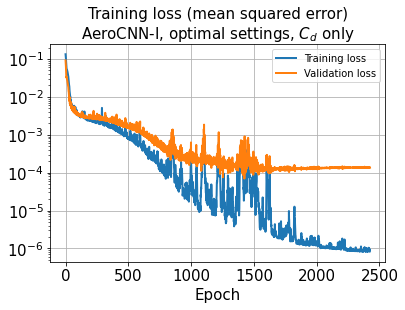

In [41]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

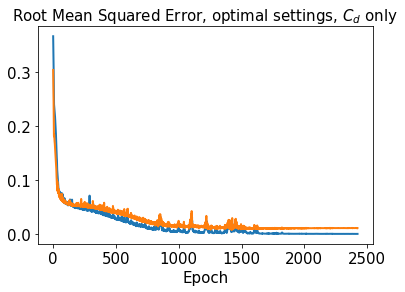

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

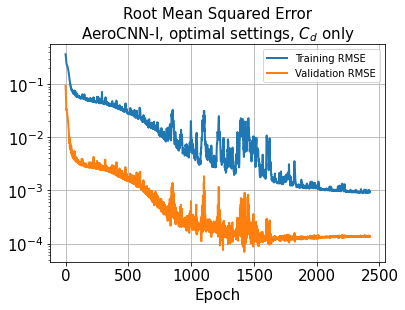

In [43]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [44]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 16ms/step - loss: 4.8823e-05 - rmse: 0.0070


In [45]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 62ms/step - loss: 3.1827e-04 - rmse: 0.0178


In [46]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 16ms/step


In [47]:
index_train = np.unique(np.where(np.isin(cd, y_train)))
index_val = np.unique(np.where(np.isin(cd, y_val)))
index_test = np.unique(np.where(np.isin(cd, y_test)))

In [48]:
y_train = y_train*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_val = y_val*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_test = y_test*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [49]:
decoded_train = decoded_train_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_val = decoded_val_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_test = decoded_test_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [50]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221130steadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_optimalSettings_Cdonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [52]:
error_val_abs = np.abs(decoded_val - y_val)

In [53]:
error_test_abs = np.abs(decoded_test - y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.014035146276532389


In [56]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.01926383310178078


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.04155218468132563


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [60]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

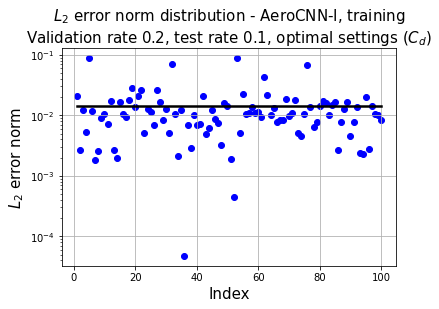

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

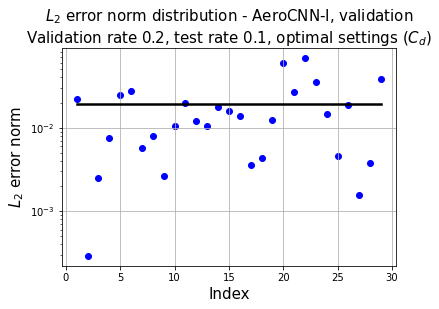

In [62]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

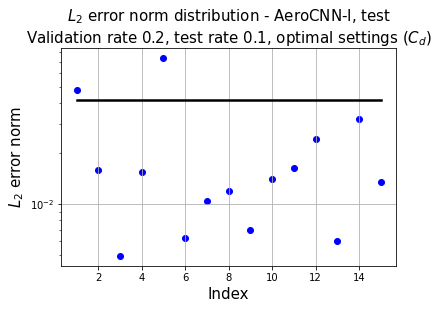

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict([x, x_para])

5/5 [==============================] - 0s 13ms/step


In [65]:
def CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest):
    
    title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    #title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    #title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cd = title_0_Cd
        savename1 = "CdComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cd = title_n_Cd
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
#         savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

    '''# CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='b', label='Training set')
    plt.scatter(aTest, iTest[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

1/1 [==============================] - 0s 55ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0131


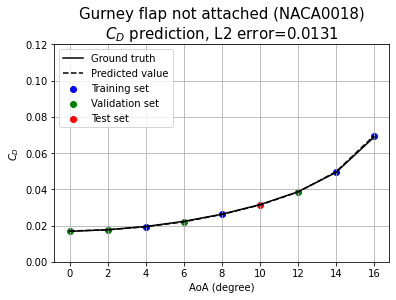

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0237


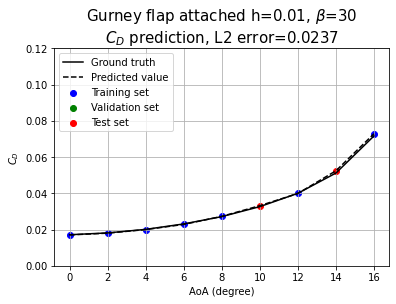

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0217


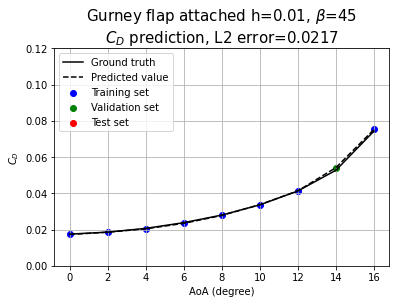

1/1 [==============================] - 0s 17ms/step
L2 error of Cd: 0.0146


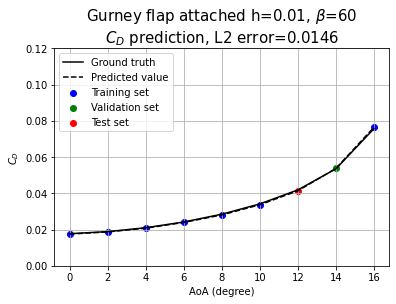

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0168


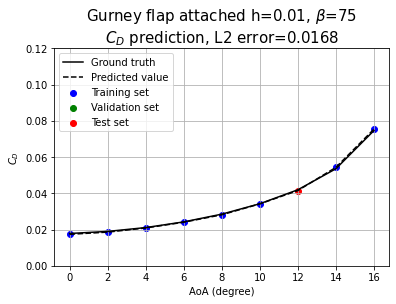

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0673


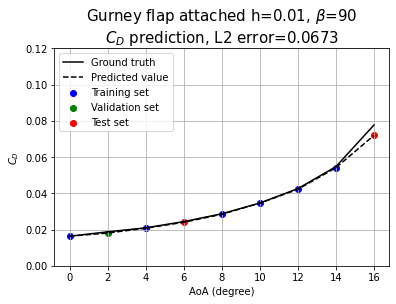

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0215


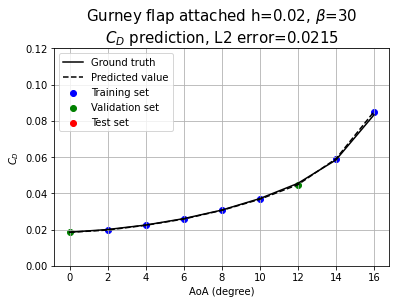

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0184


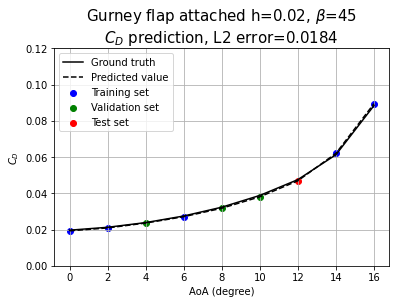

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0095


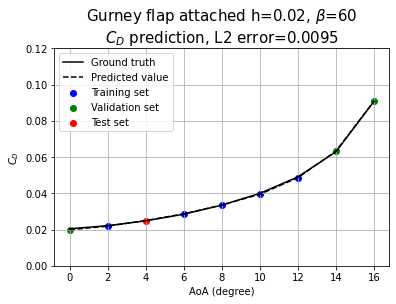

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0270


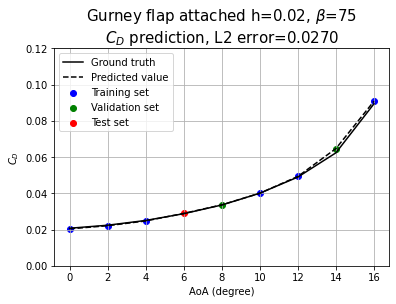

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0330


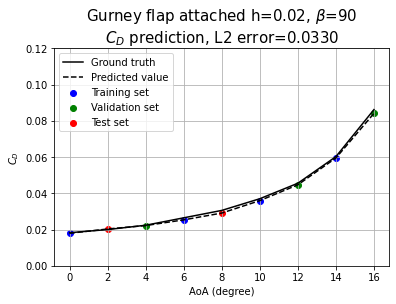

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0198


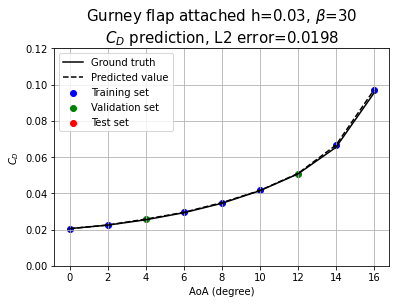

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0162


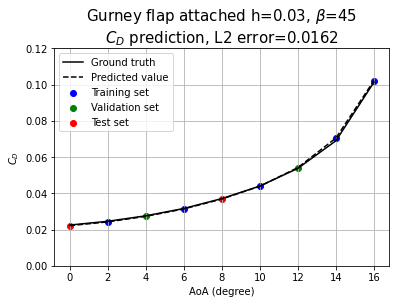

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0105


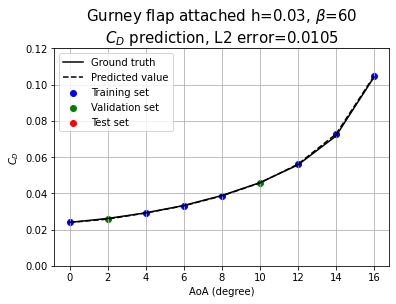

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0177


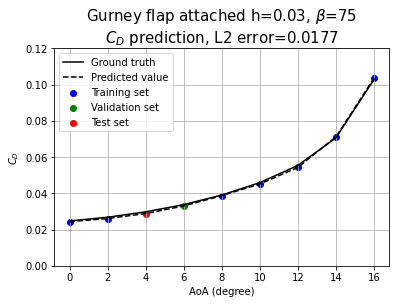

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0486


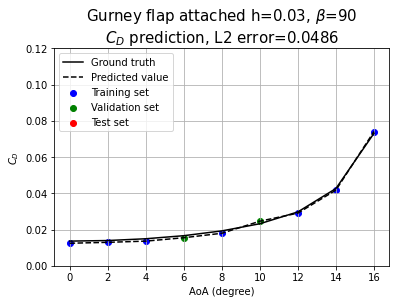

In [66]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:],x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    
    cd = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    CD = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iTest = np.array(iTest)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iVal = np.array(iVal)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest)